In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV,train_test_split,KFold
from sklearn.metrics import mean_squared_error,accuracy_score,precision_recall_fscore_support,precision_score,roc_auc_score,roc_curve,confusion_matrix
import warnings
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')
from scipy.spatial import distance
from sklearn.cluster import SpectralClustering
import copy

In [183]:
banknote_data=pd.read_csv("https://raw.githubusercontent.com/71sgupta/HW6_ML/master/data_banknote_authentication.csv",header=None)
features_bank=[]
for i in banknote_data.columns:
    features_bank.append("bank_"+str(i))
banknote_data.columns=features_bank
bank_data_train,bank_data_test=train_test_split(banknote_data,train_size=0.6559766763848397)

print("Train Data:")
print(bank_data_train.head())

print("Test Data:")
print(bank_data_test.head())

Train Data:
        bank_0   bank_1   bank_2   bank_3  bank_4
1284  1.208000  4.07440 -4.76350 -2.61290       1
872  -0.954030  1.98240 -2.31630 -1.19570       1
482   0.007125  8.36610  0.50781 -3.81550       0
480   0.947320 -0.57113  7.19030 -0.67587       0
510   3.577000  2.40040  1.89080  0.73231       0
Test Data:
       bank_0   bank_1   bank_2   bank_3  bank_4
468   4.57070   7.2094 -3.27940 -1.49440       0
1082 -1.39460   2.3134 -0.44499 -1.49050       1
384   0.54777  10.3754 -1.54350 -4.16330       0
1137 -1.58770  -6.6072  5.80220  0.31593       1
1050 -5.88180   7.6584  0.55580 -2.91550       1


# 2 b) i) Passive Learning

In [ ]:
final_res=[]

temp_train=bank_data_train
for j in range(0,50):
    temp_train=copy.deepcopy(bank_data_train)
    test_data_X=bank_data_test.iloc[:,:-1]
    test_data_Y=bank_data_test.iloc[:,-1]
    train_data_new=[]
    temp_res=[]
    temp_train_data=temp_train[temp_train.bank_4==0].sample(n=5)
    temp_train_data=pd.concat([temp_train_data,temp_train[temp_train.bank_4==1].sample(n=5)],axis=0)
    for i in range(0,90):
        #temp_train_data=bank_data_train.sample(n=10)
        train_data_new=pd.concat([pd.DataFrame(train_data_new),temp_train_data],axis=0)
        #print(len(train_data_new))
        train_data_X=train_data_new.iloc[:,:-1]
        train_data_Y=train_data_new.iloc[:,-1]

        svcmodel=LinearSVC(penalty='l1',dual=False)
        params_dict={'C':np.logspace(-3,6,10)}
        searchmodel=GridSearchCV(svcmodel,params_dict,cv=KFold(10))

        searchmodel.fit(train_data_X,train_data_Y)

        test_pred=searchmodel.predict(test_data_X)
        #train_pred=searchmodel.predict(train_data_X)
        temp_res.append(mean_squared_error(test_data_Y,test_pred))
        temp_train.drop(temp_train_data.index.tolist(),inplace=True)
        if(len(temp_train)>0):
            temp_train_data=temp_train.sample(n=10)
        #print(len(bank_data_train))
    final_res.append(temp_res)

In [189]:
print("Test Errors for 90 SVMs: ")
print(pd.DataFrame(final_res))
y=pd.DataFrame(final_res).describe()
y1=y.iloc[1:2,:]

Test Errors for 90 SVMs: 
          0         1         2         3         4         5         6   \
0   0.156780  0.101695  0.057203  0.063559  0.057203  0.027542  0.027542   
1   0.023305  0.014831  0.067797  0.057203  0.021186  0.031780  0.031780   
2   0.110169  0.059322  0.063559  0.133475  0.021186  0.031780  0.031780   
3   0.135593  0.144068  0.067797  0.076271  0.027542  0.069915  0.044492   
4   0.065678  0.036017  0.033898  0.025424  0.025424  0.023305  0.012712   
5   0.042373  0.010593  0.023305  0.019068  0.033898  0.012712  0.012712   
6   0.141949  0.120763  0.042373  0.059322  0.061441  0.059322  0.025424   
7   0.042373  0.019068  0.019068  0.004237  0.002119  0.010593  0.008475   
8   0.012712  0.004237  0.004237  0.006356  0.006356  0.016949  0.008475   
9   0.067797  0.029661  0.019068  0.002119  0.006356  0.014831  0.012712   
10  0.101695  0.095339  0.097458  0.052966  0.021186  0.023305  0.031780   
11  0.095339  0.027542  0.063559  0.033898  0.055085  0.023305

# 2 b) ii) Active Learning

In [176]:
final_res1=[]
temp_train=bank_data_train
for j in range(0,50):
    temp_train=copy.deepcopy(bank_data_train)
    test_data_X=bank_data_test.iloc[:,:-1]
    test_data_Y=bank_data_test.iloc[:,-1]
    train_data_new=[]
    temp_res=[]
    temp_train_data=bank_data_train[temp_train.bank_4==0].sample(n=5)
    temp_train_data=pd.concat([temp_train_data,temp_train[temp_train.bank_4==1].sample(n=5)],axis=0)
    for i in range(0,90):
        
        train_data_new=pd.concat([pd.DataFrame(train_data_new),temp_train_data],axis=0)
        #print(len(train_data_new))
        train_data_X=train_data_new.iloc[:,:-1]
        train_data_Y=train_data_new.iloc[:,-1]

        svcmodel=LinearSVC(penalty='l1',dual=False)
        params_dict={'C':np.logspace(-3,6,10)}
        searchmodel=GridSearchCV(svcmodel,params_dict,cv=KFold(10))
        #print(train_data_Y)
        searchmodel.fit(train_data_X,train_data_Y)
        
        #bank_data_train.drop(temp_train_data.index.tolist(),inplace=True)
        
        conf_val=abs(searchmodel.decision_function(temp_train.iloc[:,:-1]))
        conf_val=pd.DataFrame(conf_val)
        conf_val.index=(temp_train.iloc[:,-1]).index
        conf_val=pd.concat([temp_train.iloc[:,-1],conf_val],axis=1)
        
        conf_val.sort_values(by=0,inplace=True)
        indexes=conf_val.iloc[0:10,:].index.tolist()
        test_pred=searchmodel.predict(test_data_X)
        #train_pred=searchmodel.predict(train_data_X)
        temp_res.append(mean_squared_error(test_data_Y,test_pred))
        temp_train_data=temp_train.loc[indexes]
        temp_train.drop(indexes,inplace=True)
        #print(len(bank_data_train.iloc[:,-1]))
        #print(len(bank_data_train))
    final_res1.append(temp_res)


In [188]:
print("Test Errors for 90 SVMs: ")
print(pd.DataFrame(final_res1))
y=pd.DataFrame(final_res1).describe()
y2=y.iloc[1:2,:]

Test Errors for 90 SVMs: 
          0         1         2         3         4         5         6   \
0   0.127119  0.038136  0.023305  0.008475  0.008475  0.016949  0.008475   
1   0.063559  0.084746  0.012712  0.036017  0.008475  0.002119  0.002119   
2   0.029661  0.036017  0.006356  0.010593  0.004237  0.002119  0.010593   
3   0.112288  0.006356  0.010593  0.008475  0.010593  0.065678  0.008475   
4   0.029661  0.021186  0.031780  0.006356  0.008475  0.002119  0.002119   
5   0.133475  0.067797  0.063559  0.031780  0.021186  0.016949  0.012712   
6   0.061441  0.036017  0.033898  0.006356  0.002119  0.002119  0.010593   
7   0.029661  0.203390  0.148305  0.065678  0.029661  0.014831  0.019068   
8   0.281780  0.069915  0.012712  0.016949  0.012712  0.006356  0.008475   
9   0.103814  0.027542  0.002119  0.019068  0.023305  0.012712  0.016949   
10  0.019068  0.008475  0.006356  0.006356  0.069915  0.010593  0.010593   
11  0.095339  0.021186  0.027542  0.008475  0.004237  0.002119

## 2 c) Learning Curve

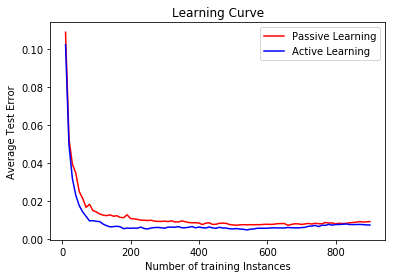

In [178]:
xval=np.arange(10,901,10)
plt.plot(xval,np.array(y1)[0],c='red',label="Passive Learning")
plt.plot(xval,np.array(y2)[0],c='blue',label="Active Learning")
plt.legend()
plt.title("Learning Curve")
plt.xlabel("Number of training Instances")
plt.ylabel("Average Test Error")
plt.show()